In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL/Challenge2

Mounted at /gdrive
/gdrive/My Drive/ANNDL/Challenge2


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split, KFold
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load Data

In [5]:
dataset = np.load('training_data.npy', allow_pickle=True)
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

In [6]:
# Split the input in indipendent sets

trainval_set, test_set, cat_trainval, cat_test, val_per_trainval, val_per_test = train_test_split(dataset, categories, valid_periods, random_state=seed, test_size=0.05, stratify=categories)
train_set, val_set, cat_train, cat_val, val_per_train, val_per_val = train_test_split(trainval_set, cat_trainval, val_per_trainval, random_state=seed, test_size=0.15, stratify=cat_trainval)


# Build the sequences for each part

def build_sequences(dataset,categories,valid_periods, size, window=200, stride=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    datasetSplit = []
    labels = []
    for i in range(0,size):
        # Take only meaningful features
        temp = dataset[i][valid_periods[i][0]:valid_periods[i][1]]
        # Save the label
        label = categories[i]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros(padding_len, dtype='float32')
        temp = np.concatenate((padding,temp))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            datasetSplit.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    datasetSplit = np.array(datasetSplit)
    labels = np.array(labels)
    return datasetSplit, labels

(train_ds, train_labels) = build_sequences(train_set,cat_train,val_per_train, train_set[...,0].size, 209,19)
train_ds = np.expand_dims(train_ds, axis=2)
(val_ds, val_labels) = build_sequences(val_set,cat_val,val_per_val, val_set[...,0].size, 209,19)
val_ds = np.expand_dims(val_ds, axis=2)
(test_ds, test_labels) = build_sequences(test_set,cat_test,val_per_test, test_set[...,0].size, 209,19)
test_ds = np.expand_dims(test_ds, axis=2)


# Split the windows in x and y

def split_output(input_ds,size = 9):
  dataset = [];
  output = [];
  for i in range(0,len(input_ds)):
    dataset.append(input_ds[i][:len(input_ds[i]) - size:])
    output.append(input_ds[i][len(input_ds[i]) - size:])
  dataset = np.array(dataset)
  output = np.array(output)
  return dataset,output

(X_train,y_train) = split_output(train_ds,9)
(X_val,y_val) = split_output(val_ds,9)
(X_test,y_test) = split_output(test_ds,9)


## Data Inspection and Visualization

In [ ]:
from collections import defaultdict

# Set the seed for reproducibility (optional)
np.random.seed(42)

# Initialize a defaultdict to store the counts
char_counts = defaultdict(int)

# Number of rows and columns
num_rows = 0
for i in range(48000):
  char_counts[categories[i]] += 1
  num_rows = num_rows - valid_periods[i][0] + valid_periods[i][1]

# Convert the defaultdict to a regular dictionary if needed
char_counts_dict = dict(char_counts)

# Print the result
print(char_counts_dict)

# Generate random data for each column
column1 = np.random.randint(1, 100, size=num_rows, dtype=int)
column2 = np.random.choice(['A', 'B', 'C', 'D', 'E'], size=num_rows)
column3 = np.random.rand(num_rows)

# Create the numpy array
data_array = np.column_stack((column1, column2, column3))
new_ds = np.empty_like(data_array)
print(num_rows)

count = 0

for i in range(48000):
  for j in range(valid_periods[i][0], valid_periods[i][1]):
    new_ds[count] = [i, categories[i], dataset[i][j]]
    count = count + 1

print(count)

column_names = ['id_series', 'category', 'value']

df = pd.DataFrame(new_ds, columns=column_names)
# df.dropna(axis=0, how='any', inplace=True)

print(df.shape)
df.head(1000)

{'D': 10016, 'E': 10975, 'A': 5728, 'C': 10017, 'B': 10987, 'F': 277}
9518411
9518411
(9518411, 3)


,id_series,category,value
0,0,D,0.49166666666666664
1,0,D,0.524074074074074
2,0,D,0.5444444444444444
3,0,D,0.4638888888888889
4,0,D,0.4064814814814815
...,...,...,...
995,2,D,0.13410458121240165
996,2,D,0.14002776492364646
997,2,D,0.13651087459509487
998,2,D,0.12188801480795927


Text(0, 0.5, 'timesteps')

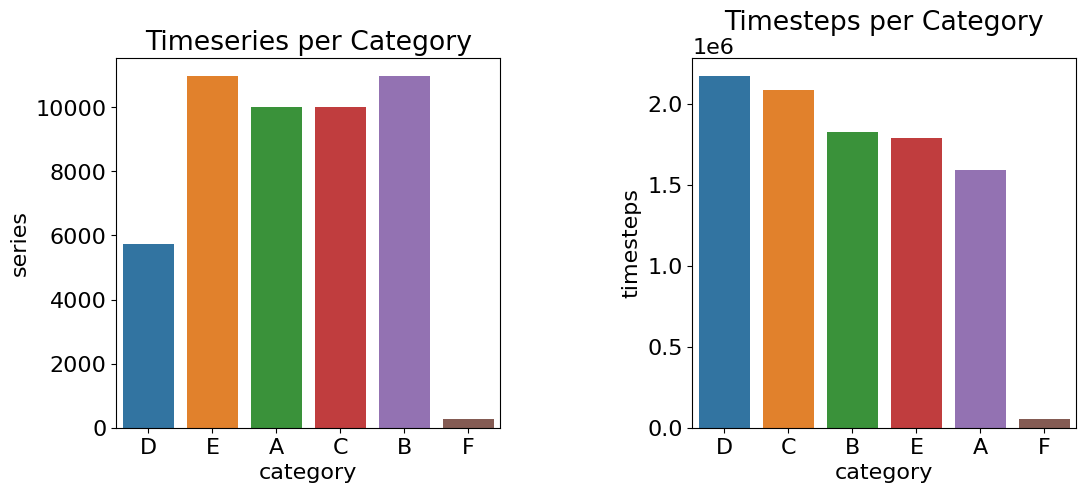

In [ ]:
# Plotting timeseries and timesteps for each category

# retrieve categories and number of timeseries for each category
keys = list(char_counts_dict.keys())
vals = [char_counts_dict[k] for k in sorted(list(char_counts_dict.keys()))]

fig, axs = plt.subplots(ncols=2)


plt.subplots_adjust(left=0.5, right=2, wspace = 0.5 )

sns.barplot(x=keys, y=vals, ax = axs[0]).title.set_text("Timeseries per Category")
axs[0].set_xlabel("category")
axs[0].set_ylabel("series")
sns.countplot(x = 'category', data = df, order = df.category.value_counts().index).title.set_text("Timesteps per Category")
axs[1].set_ylabel("timesteps")

In [ ]:
grouped_df = df.groupby('id_series')['value'].apply(list).to_dict()

In [ ]:
for key, value in grouped_df.items():
    grouped_df[key] = [float(val) for val in value]

print(grouped_df['0'])

[0.49166666666666664, 0.524074074074074, 0.5444444444444444, 0.4638888888888889, 0.4064814814814815, 0.35462962962962963, 0.31296296296296294, 0.36666666666666664, 0.38333333333333336, 0.2796296296296296, 0.23796296296296296, 0.2574074074074074, 0.47962962962962963, 0.4324074074074074, 0.5351851851851852, 0.48055555555555557, 0.37592592592592594, 0.3861111111111111, 0.32685185185185184, 0.36666666666666664, 0.25555555555555554, 0.23981481481481481, 0.2111111111111111, 0.26481481481481484, 0.4685185185185185, 0.46944444444444444, 0.4166666666666667, 0.4398148148148148, 0.3611111111111111, 0.32592592592592595, 0.3074074074074074, 0.3425925925925926, 0.2861111111111111, 0.27870370370370373, 0.18425925925925926, 0.2111111111111111, 0.3851851851851852, 0.375, 0.4444444444444444, 0.3296296296296296, 0.38981481481481484, 0.29444444444444445, 0.27037037037037037, 0.3351851851851852, 0.31666666666666665, 0.3148148148148148, 0.28888888888888886, 0.31203703703703706, 0.39444444444444443, 0.475, 0

In [ ]:
def find_outliers(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    outliers = [val for val in data if val < lower_bound or val > upper_bound]
    return outliers

outliers_dict = {}

tot_out = 0
for key, values in grouped_df.items():
    array_data = np.array(values)
    outliers = find_outliers(array_data)
    outliers_dict[key] = {
        'count': len(outliers),
        'values': outliers,
    }
    tot_out += len(outliers)

print(tot_out/len(grouped_df))

3.150729166666667


In [ ]:
# Count the number of timestamp we have for each one of the categories

# Initialize a defaultdict to store the counts
char_counts2 = defaultdict(int)

for i in range(48000):
  char_counts2[categories[i]] = char_counts2[categories[i]] + valid_periods[i][1] - valid_periods[i][0]

# Convert the defaultdict to a regular dictionary if needed
char_counts_dict2 = dict(char_counts2)

# Print the result
print(char_counts_dict2)

{'D': 2173381, 'E': 1789430, 'A': 1593417, 'C': 2085001, 'B': 1823214, 'F': 53968}


In [ ]:
# Check the minimum and maximum value for all the timeseries referring to the same categories

char_min_max_dict = defaultdict(lambda: {'min': float('inf'), 'max': float('-inf')})

for i in range(48000):
    char_min_max_dict[categories[i]]['min'] = min(char_min_max_dict[categories[i]]['min'], np.min(dataset[i][valid_periods[i][0]:valid_periods[i][1]]))
    char_min_max_dict[categories[i]]['max'] = max(char_min_max_dict[categories[i]]['max'], np.max(dataset[i][valid_periods[i][0]:valid_periods[i][1]]))

result_dict = dict(char_min_max_dict)

print(result_dict)

{'D': {'min': 0.0, 'max': 1.0}, 'E': {'min': 0.0, 'max': 1.0}, 'A': {'min': 0.0, 'max': 1.0}, 'C': {'min': 0.0, 'max': 1.0}, 'B': {'min': 0.0, 'max': 1.0}, 'F': {'min': 0.0, 'max': 1.0}}


In [ ]:
csv_filename = 'my_dataframe.csv'
df.to_csv(csv_filename, index=False)

In [ ]:
df['id_series'] = df['id_series'].astype(np.int64)
df['value'] = df['value'].astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9518411 entries, 0 to 9518410
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id_series  int64  
 1   category   object 
 2   value      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 217.9+ MB


In [ ]:
df.describe()

,id_series,value
count,9.518411e+06,9.518411e+06
mean,2.249086e+04,4.250845e-01
std,1.365494e+04,2.697224e-01
min,0.000000e+00,0.000000e+00
25%,1.085600e+04,1.909514e-01
50%,2.389400e+04,4.034012e-01
75%,3.355800e+04,6.407508e-01
max,4.799900e+04,1.000000e+00


## Autocorrelation

In [ ]:
df = pd.DataFrame(X_train[...,0])
df = df.transpose()

max_ac = 0.6
len = 10000

# prints the windows with an higher maximum autocorrelation than max_ac and the lag it was reached with, among the first len windows
for i in range(len):
  max_corr = 0.0
  for lagvar in range (1,150):
    corr = abs(df[i].diff().autocorr(lag=lagvar))
    if(not math.isnan(corr)):
     max_corr = max(corr,max_corr)
     if(max_corr == corr):
        max_lag = lagvar
  if(abs(max_corr)<max_ac):
    print(cat_train[i]+","+str(i)+": "+str(max_corr)+" with a lag of "+str(max_lag))
    count+=1

In [ ]:
max_lag = 60
max_ac = 0.8

df = pd.DataFrame(dataset)
df = df.transpose()
to_remove = []

# creates a list of the series in the dataset with a lower autocorrelation than 0.8 in a ragen of lag from 1 to max_lag
for i in range(48000):
  max_corr = 0.0
  for lagvar in range (1,max_lag+1):
    corr = abs(df[i][valid_periods[i][0]:valid_periods[i][1]].autocorr(lag=lagvar))
    if(not math.isnan(corr)):
     max_corr = max(corr,max_corr)
  if(abs(max_corr) < max_ac):
    to_remove.append(i)

In [ ]:
dataset = np.delete(dataset,to_remove,axis=0)
categories = np.delete(categories,to_remove)
valid_periods = np.delete(valid_periods,to_remove,axis=0)

## First Model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512
epochs = 200

(246784, 200, 1)
(200, 1)
200
9


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    crop_size = output_layer.shape[1] - output_shape[0]

    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

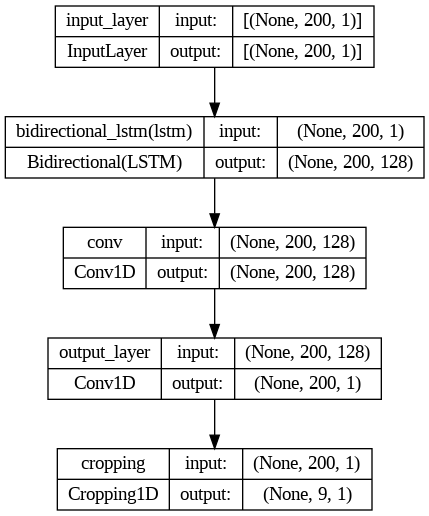

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

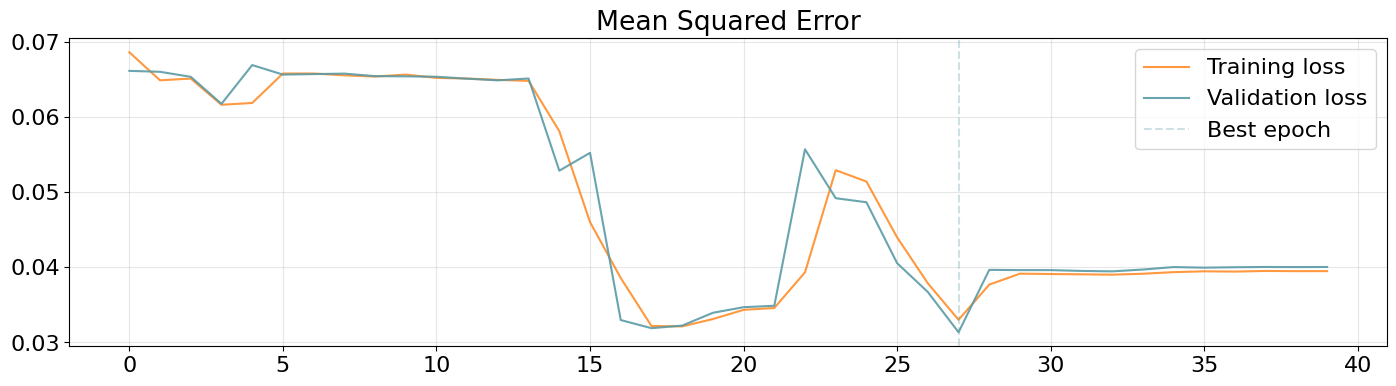

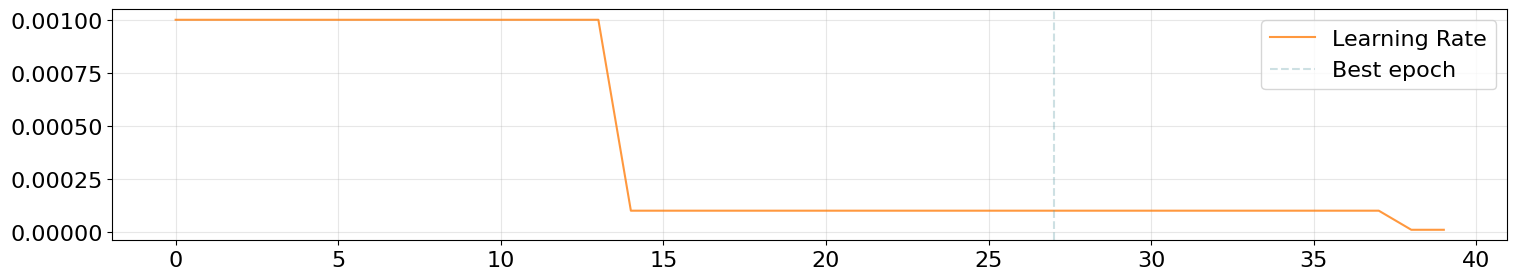

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
test_loss = model.evaluate(X_test,y_test)
print('test loss: ',test_loss)

508/508 [==============================] - 5s 10ms/step - loss: 0.0315
test loss:  0.03153598681092262


## Convolutional-based Models

These are the category of models mainly used during the first phase while experimenting with autocorrelation analysis and with category-based models. Different versions with different values of parameters are omitted for clarity.

### First implementation

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    model = tfk.Sequential()
    model.add(tfkl.Input(shape=input_shape, name='Input'))
    model.add(tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True)))
    # model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(tfkl.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(tfkl.Flatten())
    # model.add(tfkl.Dropout(0.4))
    model.add(tfkl.Dense(32, activation='leaky_relu'))
    model.add(tfkl.Dense(9))

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics = ['mae'])

    return model

### Model with GAP

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    model = tfk.Sequential()
    model.add(tfkl.Input(shape=input_shape, name='Input'))
    model.add(tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True)))
    # model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(tfkl.GlobalAveragePooling1D())
    # model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Dense(32, activation='leaky_relu'))
    model.add(tfkl.Dense(9))

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics = ['mae'])

    return model

### Training

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_mae', mode='min', patience=5, factor=0.8,min_lr=1e-5)
    ]
).history

### Evaluation

In [ ]:
# plot the graph with training and validation loss
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plot the graph with the history of the learning rate
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

print("The best epoch is:" + str(best_epoch))

In [ ]:
test_loss = model.evaluate(X_test,y_test)
print('test loss: ',test_loss)

## Attention Model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 256

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, GlobalAveragePooling1D, Dropout, Bidirectional, Attention, Reshape
def build_CONV_LSTM_attention_model(input_shape, output_shape):

    input_layer = Input(shape=input_shape, name='Input')

    convlstm = Bidirectional(LSTM(128, return_sequences=True))(input_layer)

    attention = Attention()([convlstm, convlstm])

    attended_out = tf.keras.layers.Concatenate(axis=-1)([convlstm, attention])

    convlstm = Conv1D(128, 3, padding='same', activation='relu')(attended_out)
    convlstm = GlobalAveragePooling1D()(convlstm)

    dense = Dense(64, activation='relu')(convlstm)
    dense = Dropout(0.30)(dense)

    output_layer = Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_Attention_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4), metrics=['mae'])

    return model

In [ ]:
model = build_CONV_LSTM_attention_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "CONV_LSTM_Attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 196, 1)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 196, 256)             133120    ['Input[0][0]']               
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 196, 256)             0         ['bidirectional[0][0]',       
                                                                     'bidirectional[0][0]']       
                                                                          

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, min_delta = 0.00005),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.8, min_lr=1e-5, min_delta = 0.00005)
    ]
).history

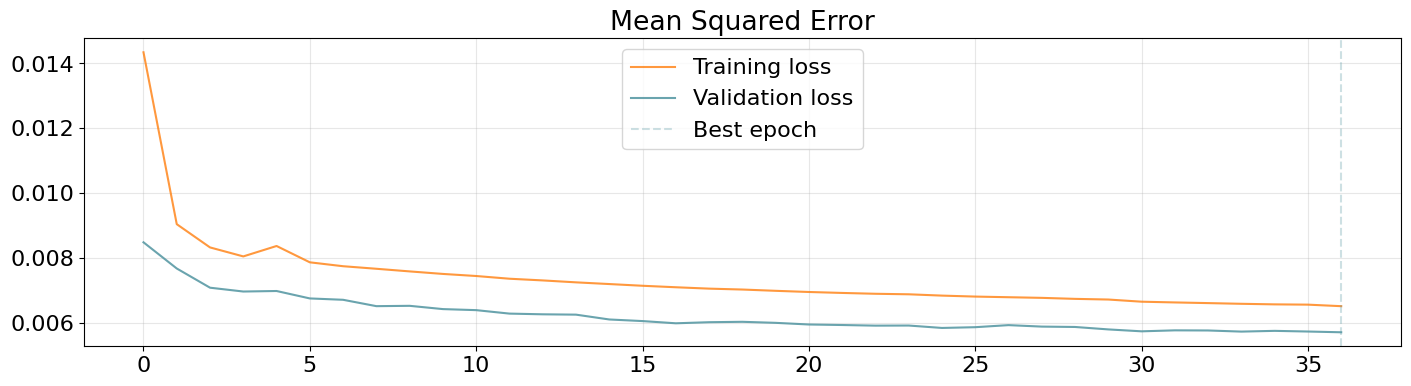

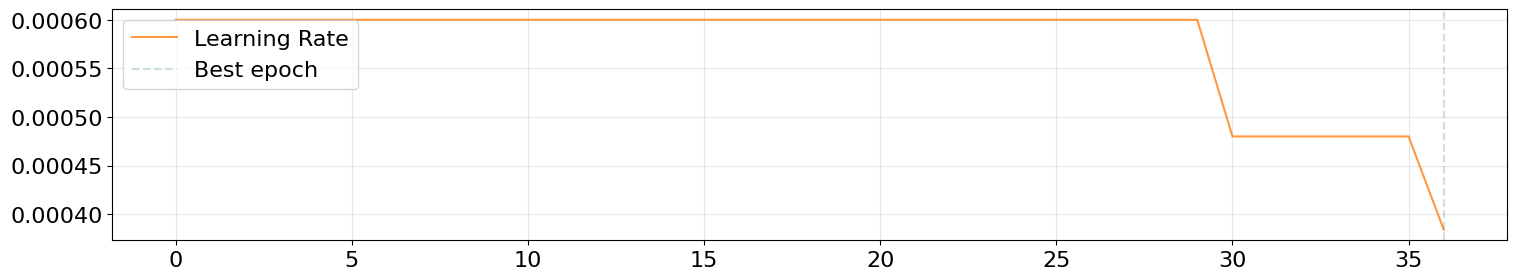

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
test_loss = model.evaluate(X_test,y_test)
print('test loss: ',test_loss)
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,5))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, ["target_labels"], 9)

In [ ]:
model.save("GAPModel_Attention")

### Category-based Data Preparation



In [ ]:
# create new versions of train, validation and test sets with concatenated categories

# convert the categories to one-hot encoding
cat_train_ohe = pd.Categorical(cat_train)._str_get_dummies()
cat_val_ohe = pd.Categorical(cat_val)._str_get_dummies()
cat_test_ohe = pd.Categorical(cat_test)._str_get_dummies()

# concatenate categories to the timeseries
X_train = np.concatenate((X_train, cat_train_ohe[0]), axis=1)
X_val = np.concatenate((X_val, cat_val_ohe[0]), axis=1)
X_test = np.concatenate((X_test, cat_test_ohe[0]), axis=1)

# expand dimensions of the datasets
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

## Autoregression

In [ ]:
window = 200
telescope = 20
auto_reg_telescope = 1
stride = 70

####Preparing Data

In [ ]:
def split_output_autoReg(input_ds,size = 9, size2 = 1):
  dataset = [];
  output = [];
  for i in range(0,len(input_ds)):
      dataset.append(input_ds[i][:len(input_ds[i]) - size])
      output.append(input_ds[i][len(input_ds[i]) - size :len(input_ds[i]) - size  + size2])
      if(size2 == 1): #to avoid doing it in the test split
        dataset.append(input_ds[i][9:len(input_ds[i]) - size +9])
        output.append(input_ds[i][len(input_ds[i]) - size +9 :len(input_ds[i]) - size +9  + size2])
        dataset.append(input_ds[i][18:len(input_ds[i]) - size +18])
        output.append(input_ds[i][len(input_ds[i]) - size+ 18 :len(input_ds[i]) - size +18 + size2])
  dataset = np.array(dataset)
  output = np.array(output)
  return dataset,output

In [ ]:
#split the train and val dataset to have one output while the test needs to be the size of the telescope
 (X_train,y_train) = split_output_autoReg(train_ds,telescope,auto_reg_telescope)
(X_val,y_val) = split_output_autoReg(val_ds,telescope,auto_reg_telescope)
(X_test,y_test) = split_output_autoReg(test_ds,telescope,telescope)
print(X_train.shape,y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

###Standard Autoregression

####Training

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 256
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0],

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    crop_size = output_layer.shape[1] - output_shape[0]

    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate= 2e-4),metrics=['mae'])

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 1, 1)              0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

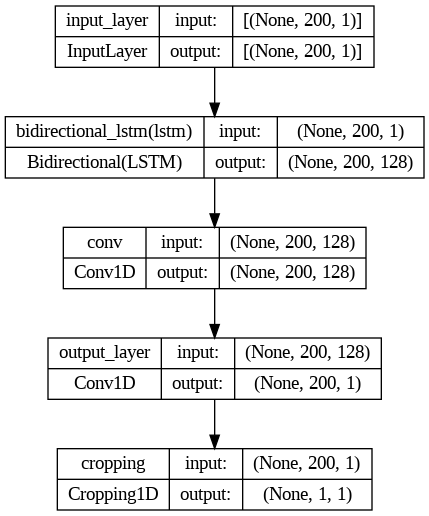

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    #validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-6),
    ]
).history
model.save("Model_Auto_Reg2")

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

####AutoRegression

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test
for reg in range(0,telescope,auto_reg_telescope):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,auto_reg_telescope:,:],pred_temp), axis=1)


In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")
print(f"Predictions shape: {y_test.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

##AutoRegression With average

###On Model with predicition of 9

In [ ]:
#load/train a model that predicts 9 values
model = tf.keras.models.load_model("Model1")
telescope = 18

In [ ]:
out = np.zeros((y_test.shape[0],telescope,1))
X_temp = X_test
for reg in range(0,telescope,1):
    #get the 9 predicted values
    pred_temp = model.predict(X_temp)
    #add predicted values to the corresponding output values
    out[:,reg:min(telescope,pred_temp.shape[1]+reg)] += pred_temp[:,:min(pred_temp.shape[1], telescope - reg)]
    #average on the number of prediction done for that value
    out[:,reg] = out[:,reg]/(min(reg+1,9))
    #add the next value to the input to predict the next 9
    X_temp = np.concatenate((X_temp[:,1:,:],np.expand_dims(out[:,reg], axis=2)), axis=1)
out = out[...,0]

In [ ]:
# Print the shape of the predictions
y_test = y_test[:,:telescope,:] #cut to telescope since to have a better stride we increased the telescope only during the split
out = np.expand_dims(out, axis=2)
print(f"Predictions shape: {out.shape}")
print(f"Predictions shape: {y_test.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (24960, 18, 1)
Predictions shape: (24960, 18, 1)
Mean Squared Error: 0.009096488651661187
Mean Absolute Error: 0.06080149805899902


###On Model with predicition of 18

In [ ]:
#load/train a model that covers the entire telescope
model = tf.keras.models.load_model("18_conv_1")
telescope = 18

In [ ]:

out = np.array([])
X_temp = X_test[:,2:] ##drop 2 because 18-conv_1 takes as input a window of 198 not 200
for reg in range(0,telescope,1):
    #get the 18 predicted values
    pred_temp = model.predict(X_temp)
    #add dimension to keep input and output shape the same
    pred_temp = np.expand_dims(pred_temp, axis=2)
    if(len(out)==0):
        out = pred_temp
    else:
        #add predicted values to the corresponding output values
        out[:,reg:] += pred_temp[:,:pred_temp.shape[1]-reg]
        #average on the number of prediction done for that value
        out[:,reg] = out[:,reg]/(reg+1)
        #add the next value to the input to predict the next 9
    X_temp = np.concatenate((X_temp[:,1:,:],np.expand_dims(out[:,reg], axis=2)), axis=1)
out = out[...,0]


In [ ]:
# Print the shape of the predictions
y_test = y_test[:,:telescope,:] #cut to telescope since to have a better stride we increased the telescope only during the split
out = np.expand_dims(out, axis=2)
print(f"Predictions shape: {out.shape}")
print(f"Predictions shape: {y_test.shape}")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (24960, 18, 1, 1)
Predictions shape: (24960, 18, 1)
Mean Squared Error: 0.01008979044854641
Mean Absolute Error: 0.06507736444473267


# Final Model

In [7]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 200

In [8]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    print(idx)
    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,5))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.scatter(np.arange(len(X[0,:]), len(X_train[0,:])+telescope), y[idx,:], color='orange')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

121958


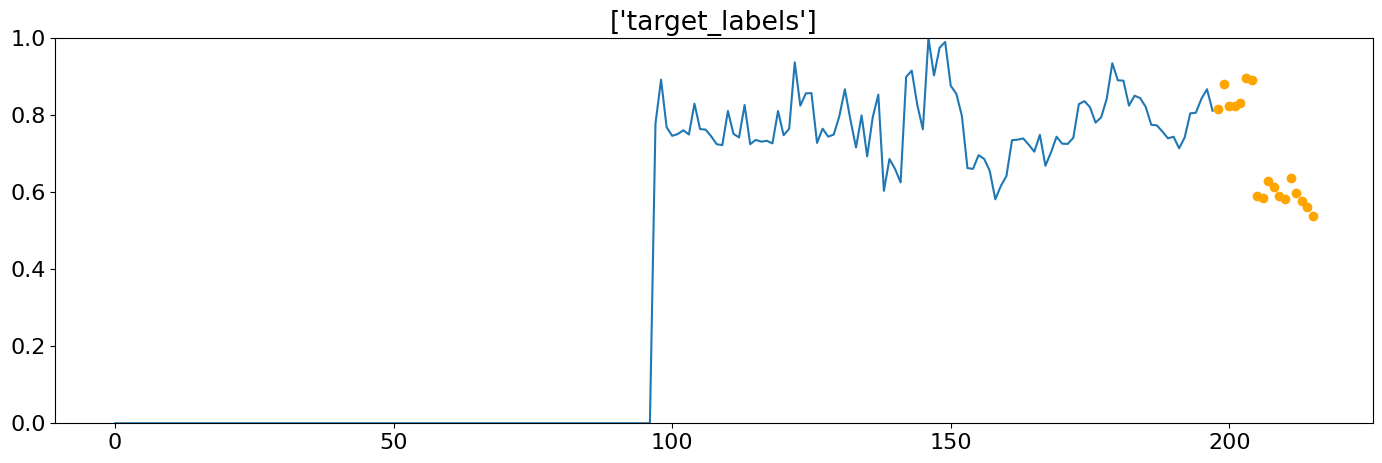

In [ ]:
inspect_multivariate(X_train, y_train, ["target_labels"], 9)

The following model was used in the last submission. It was trained on samples obtained in the autocorrelation analysis by considering only samples with maximum autocorrelation higher than 0.9.

In [9]:
def build_CONV_LSTM_model(input_shape, output_shape):

    model = tfk.Sequential()
    model.add(tfkl.Input(shape=input_shape, name='Input'))
    model.add(tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True)))
    model.add(tfkl.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(tfkl.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(32, activation='leaky_relu'))
    model.add(tfkl.Dense(9))

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics = ['mae'])

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 200, 128)          33792     
 al)                                                             
                                                                 
 conv1d (Conv1D)             (None, 199, 32)           8224      
                                                                 
 max_pooling1d (MaxPooling1  (None, 99, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            4160      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                        

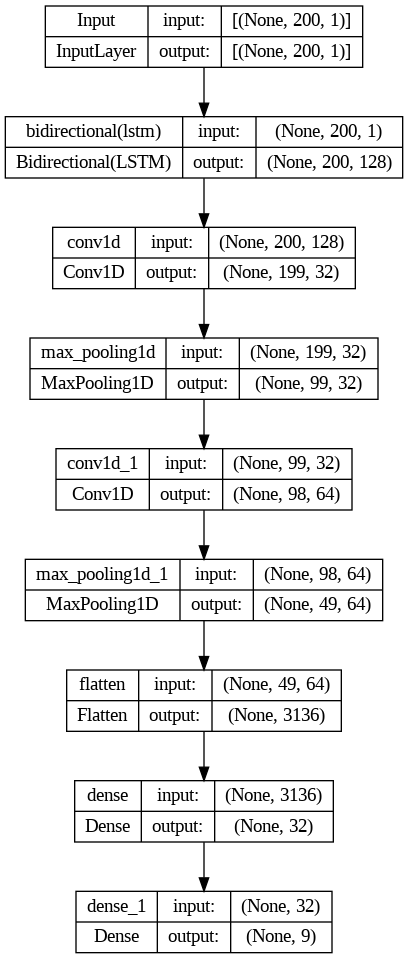

In [10]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
model_checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    filepath='/gdrive/My Drive/ANNDL/Challenge2/FinalModel',
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose=1)

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-6),
        model_checkpoint_callback
    ]
).history

In [ ]:
model.save("Final_Model")

In [12]:
model = tfk.models.load_model("Final_Model")

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
telescope = 18

out = np.zeros((y_test.shape[0],telescope,1))
X_temp = X_test
for reg in range(0,telescope,1):
    #get the 9 predicted values
    pred_temp = model.predict(X_temp)
    #add predicted values to the corresponding output values
    out[:,reg:min(telescope,pred_temp.shape[1]+reg)] += pred_temp[:,:min(pred_temp.shape[1], telescope - reg)]
    #average on the number of prediction done for that value
    out[:,reg] = out[:,reg]/(min(reg+1,9))
    #add the next value to the input to predict the next 9
    X_temp = np.concatenate((X_temp[:,1:,:],np.expand_dims(out[:,reg], axis=2)), axis=1)
out = out[...,0]

In [ ]:
test_loss = model.evaluate(X_test,y_test)
print('test loss: ',test_loss)
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [20]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,5))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

In [27]:
predictions_final = np.expand_dims(predictions, axis=2)

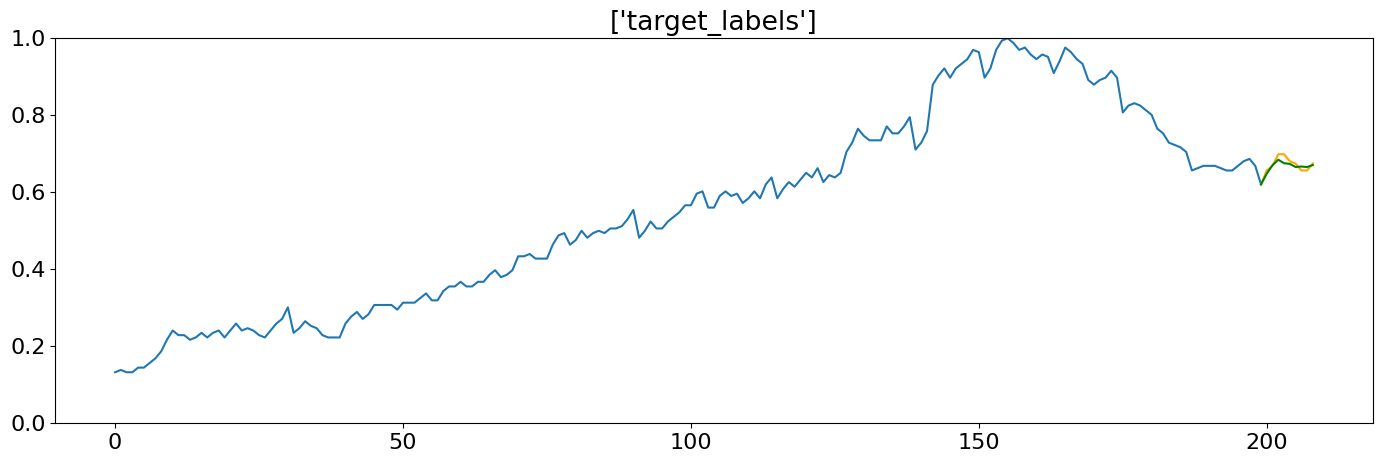

In [38]:
inspect_multivariate_prediction(X_test, y_test, predictions_final, ["target_labels"], 9)

The final model was lodead in the last phase of the challenge by using the average-based autoregressive model by adding the following script in the model.py file of the submission:

In [ ]:
telescope = 18

out = np.zeros((y_test.shape[0],telescope,1))
X_temp = X_test
for reg in range(0,telescope,1):
    #get the 9 predicted values
    pred_temp = model.predict(X_temp)
    pred_temp = np.expand_dims(pred_temp, axis=2)
    #add predicted values to the corresponding output values
    out[:,reg:min(telescope,pred_temp.shape[1]+reg)] += pred_temp[:,:min(pred_temp.shape[1], telescope - reg)]
    #average on the number of prediction done for that value
    out[:,reg] = out[:,reg]/(min(reg+1,9))
    #add the next value to the input to predict the next 9
    X_temp = np.concatenate((X_temp[:,1:,:],np.expand_dims(out[:,reg], axis=2)), axis=1)
out = out[...,0]